## P105_Internet Traffic Prediction

## import necessary libraries

In [311]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime
import itertools

import sklearn
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox 

import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

import warnings
warnings.filterwarnings("ignore")
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
import pmdarima as pm

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [312]:
Visitors_Data = pd.read_csv("Website Vistiors Daywise - Sheet1.csv")
Visitors_Data.head()

,Date,Daily Visitors
0,01-10-2021,2649
1,02-10-2021,2000
2,03-10-2021,2011
3,04-10-2021,3219
4,05-10-2021,3870


In [313]:
Visitors_Data.shape

(173, 2)

In [314]:
Visitors_Data['Daily Visitors'].describe()

count     173.000000
mean     2829.907514
std       765.194741
min      1245.000000
25%      2336.000000
50%      2751.000000
75%      3207.000000
max      7165.000000
Name: Daily Visitors, dtype: float64

In [315]:
Visitors_Data.isna().sum()

Date              0
Daily Visitors    0
dtype: int64

In [316]:
Visitors_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            173 non-null    object
 1   Daily Visitors  173 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


In [317]:
Visitors_Data = pd.read_csv('Website Vistiors Daywise - Sheet1.csv')
Visitors_Data.columns = ['Date','Daily_Visitors']
Visitors_Data['Date'] = pd.to_datetime(Visitors_Data['Date'], format='%d-%m-%Y')
Visitors_Data = Visitors_Data.set_index('Date')
Visitors_Data.head()

,Daily_Visitors
Date,
2021-10-01,2649
2021-10-02,2000
2021-10-03,2011
2021-10-04,3219
2021-10-05,3870


In [318]:
Visitors_Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 173 entries, 2021-10-01 to 2022-03-22
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Daily_Visitors  173 non-null    int64
dtypes: int64(1)
memory usage: 2.7 KB


<AxesSubplot:xlabel='Date'>

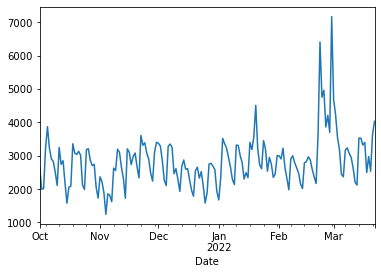

In [319]:
Visitors_Data['Daily_Visitors'].plot()

<AxesSubplot:xlabel='Daily_Visitors'>

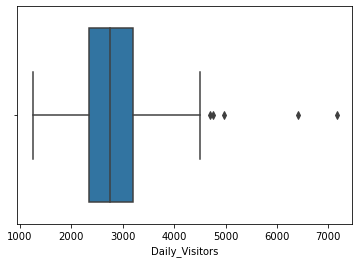

In [320]:
import seaborn as sns
sns.boxplot(Visitors_Data['Daily_Visitors'])

<AxesSubplot:ylabel='Density'>

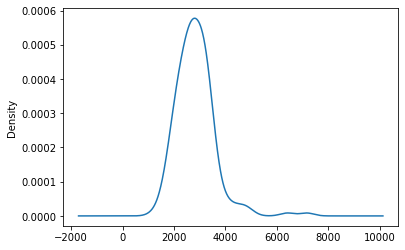

In [321]:
Visitors_Data['Daily_Visitors'].plot(kind='kde')

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

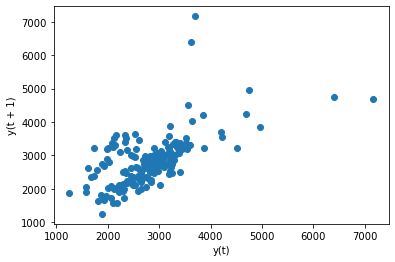

In [322]:
from pandas.plotting import lag_plot

lag_plot(Visitors_Data['Daily_Visitors'])

### Transforming data to normal distribution

In [323]:
def diagnostic_plots(Visitors_Data, variable):
    # function to plot a histogram and a Q-Q plot
    # side by side, for a certain variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    Visitors_Data[variable].hist()

    plt.subplot(1, 2, 2)
    stats.probplot(Visitors_Data[variable], dist="norm", plot=plt)

    plt.show()

### Log Transformation

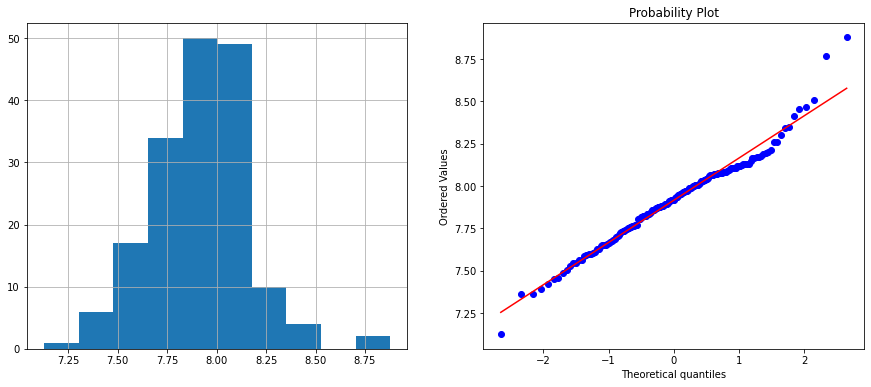

In [324]:
from scipy import stats
Visitors_Data['Log_Daily_Visitors']=np.log(Visitors_Data['Daily_Visitors']+1)
diagnostic_plots(Visitors_Data,'Log_Daily_Visitors')

### Reciprocal Transformation

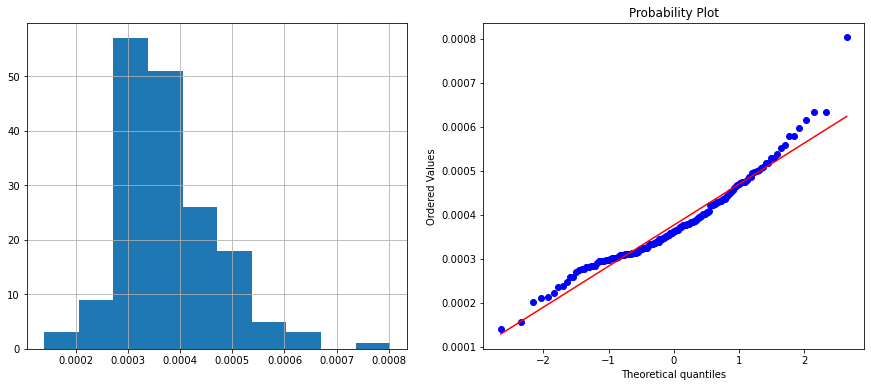

In [325]:
Visitors_Data['Rec_Daily_Visitors']=1/(Visitors_Data['Daily_Visitors']+1)
diagnostic_plots(Visitors_Data,'Rec_Daily_Visitors')

### Square-Root Transformation

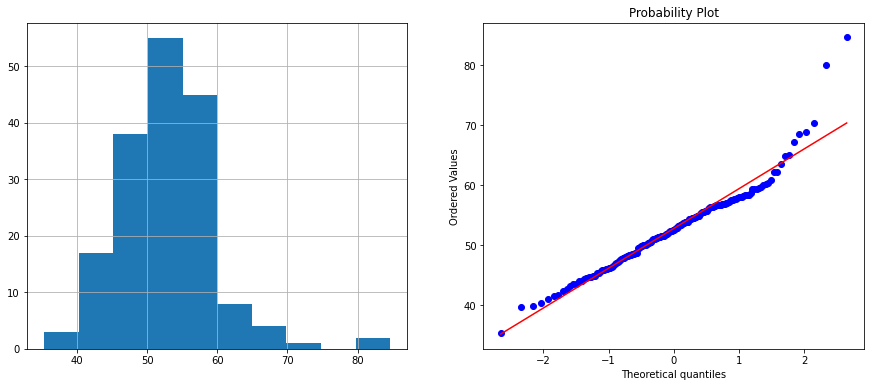

In [326]:
Visitors_Data['sqr_Daily_Visitors']=Visitors_Data['Daily_Visitors']**(1/2)
diagnostic_plots(Visitors_Data,'sqr_Daily_Visitors')

### Exponential Transformation

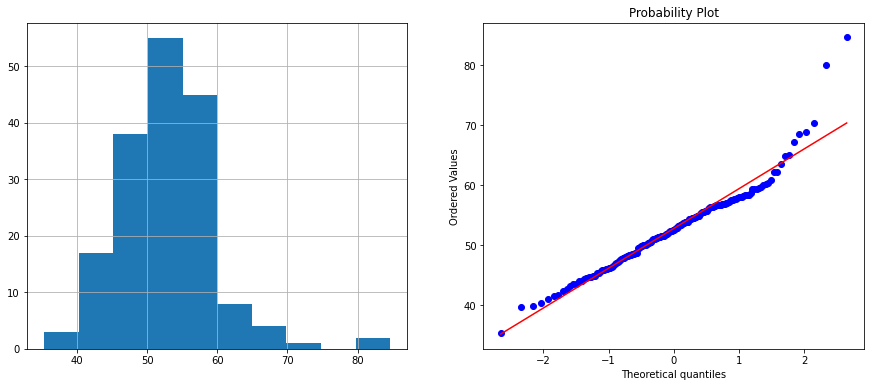

In [327]:
Visitors_Data['Exp_Daily_Visitors']=Visitors_Data['Daily_Visitors']**(1/5)
diagnostic_plots(Visitors_Data,'sqr_Daily_Visitors')

### Box-cox Transformation

Optimal lambda:  -0.21162079946684115


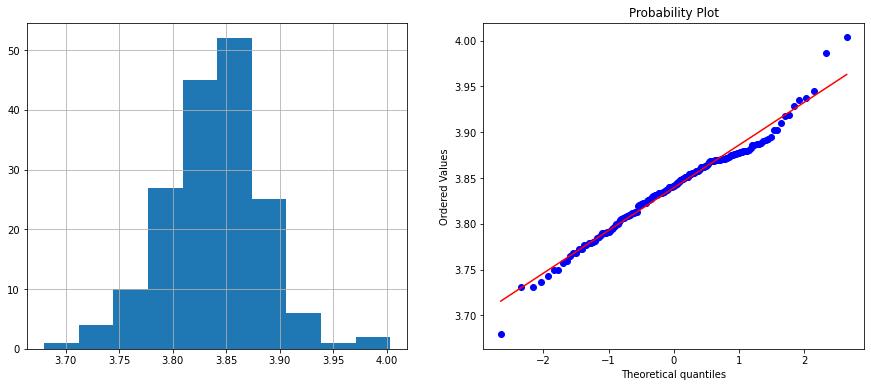

In [328]:
Visitors_Data['Daily_Visitors_boxcox'], param = stats.boxcox(Visitors_Data.Daily_Visitors+1) # you can vary the exponent as needed

print('Optimal lambda: ', param)

diagnostic_plots(Visitors_Data, 'Daily_Visitors_boxcox')

In [329]:
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox 

array([[-0.11094155, -0.11209232,  0.11094163, -0.11094155, -0.11094155,
        -0.11394968],
       [-1.2832395 , -1.28151059,  1.28325647, -1.2832395 , -1.2832395 ,
        -1.28137908],
       [-1.25968796, -1.25803212,  1.25970486, -1.25968795, -1.25968795,
        -1.25800822],
       ...,
       [-0.29148529, -0.29233837,  0.29148894, -0.29148529, -0.29148529,
        -0.29429018],
       [ 1.1345945 ,  1.13402396, -1.13460856,  1.1345945 ,  1.1345945 ,
         1.13555973],
       [ 1.51571508,  1.51657556, -1.51572487,  1.51571509,  1.51571509,
         1.51976046]])

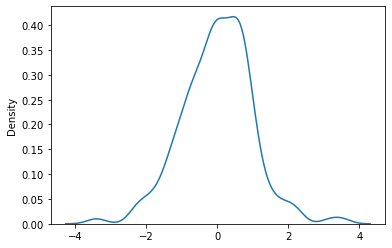

In [330]:
pt = PowerTransformer(method='box-cox')
data = pt.fit_transform(Visitors_Data)
sns.distplot(data, hist=False, kde=True)
data

<AxesSubplot:ylabel='Density'>

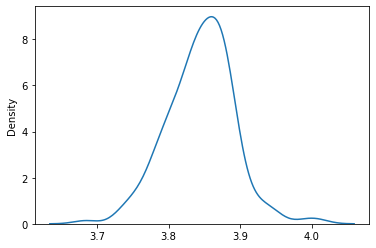

In [331]:
#perform Box-Cox transformation on original data
transformed_data, best_lambda = boxcox(Visitors_Data.Daily_Visitors) 

#plot the distribution of the transformed data values
sns.distplot(transformed_data, hist=False, kde=True)

In [332]:
Visitors_Data.dtypes

Daily_Visitors             int64
Log_Daily_Visitors       float64
Rec_Daily_Visitors       float64
sqr_Daily_Visitors       float64
Exp_Daily_Visitors       float64
Daily_Visitors_boxcox    float64
dtype: object

<AxesSubplot:xlabel='Date'>

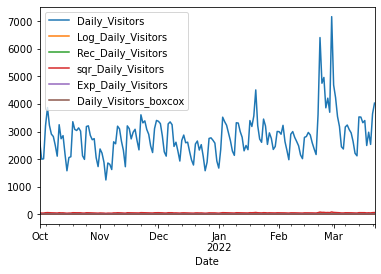

In [333]:
Visitors_Data.plot()

<AxesSubplot:xlabel='Date'>

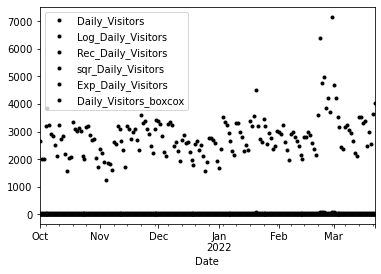

In [334]:
Visitors_Data.plot(style = 'k.')

In [335]:
Visitors_Data.describe()

,Daily_Visitors,Log_Daily_Visitors,Rec_Daily_Visitors,sqr_Daily_Visitors,Exp_Daily_Visitors,Daily_Visitors_boxcox
count,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000
mean,2829.907514,7.916344,0.000376,52.765757,4.876581,3.839325
std,765.194741,0.250185,0.000095,6.778494,0.245998,0.046701
min,1245.000000,7.127694,0.000140,35.284558,4.159430,3.679833
25%,2336.000000,7.756623,0.000312,48.332184,4.717312,3.810134
50%,2751.000000,7.920083,0.000363,52.449976,4.874141,3.841254
75%,3207.000000,8.073403,0.000428,56.630381,5.025969,3.869481
max,7165.000000,8.877103,0.000803,84.646323,5.902598,4.003354


In [2]:
Visitors_Data.hist(figsize =(15,6))

NameError: name 'Visitors_Data' is not defined

#### Since we didnot get any conclusive evidence of being normal distribution. We have decided to move on without transforming it to normal distribution

### Dropping all transformed values from dataset

In [337]:
Visitors_Data= Visitors_Data.drop(['Daily_Visitors_boxcox', 'Log_Daily_Visitors','Rec_Daily_Visitors','sqr_Daily_Visitors','Exp_Daily_Visitors'], axis = 1)

In [338]:
Visitors_Data.head()

,Daily_Visitors
Date,
2021-10-01,2649
2021-10-02,2000
2021-10-03,2011
2021-10-04,3219
2021-10-05,3870


In [339]:
Visitors_Data.dtypes

Daily_Visitors    int64
dtype: object

In [340]:
Visitors_Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 173 entries, 2021-10-01 to 2022-03-22
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Daily_Visitors  173 non-null    int64
dtypes: int64(1)
memory usage: 2.7 KB


<AxesSubplot:xlabel='Date'>

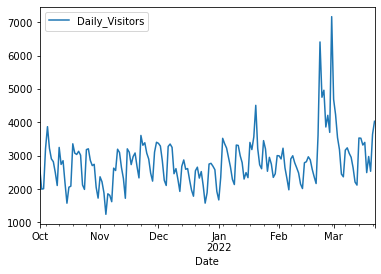

In [341]:
Visitors_Data.plot()

<AxesSubplot:xlabel='Date'>

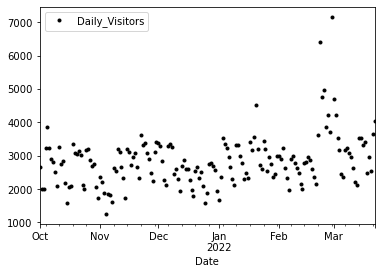

In [342]:
Visitors_Data.plot(style = 'k.')

In [343]:
Visitors_Data.describe()

,Daily_Visitors
count,173.000000
mean,2829.907514
std,765.194741
min,1245.000000
25%,2336.000000
50%,2751.000000
75%,3207.000000
max,7165.000000


array([[<AxesSubplot:title={'center':'Daily_Visitors'}>]], dtype=object)

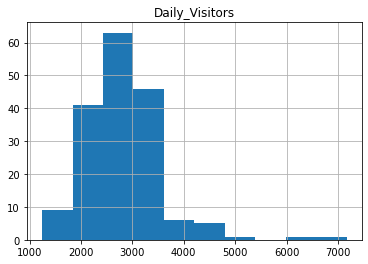

In [344]:
Visitors_Data.hist()

## A) MODEL BUILDING ON STATIONARY DATA

### Test Stationary

#### Naive test for stationary by checking constant mean and variance

In [345]:
X = Visitors_Data.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=2612.651163, mean2=3044.666667
variance1=307739.529475, variance2=760604.107280


##### Since mean and variance changes drastically it is evident that out data is not stationary. Let's confirm it using ADFuller test.

### Testing Stationary using ADFuller test

In [346]:
def TestStationaryPlot(Visitors_Data):
    rol_mean = Visitors_Data.rolling(window = 20, center = False).mean()
    rol_std = Visitors_Data.rolling(window = 20, center = False).std()
    
    plt.plot(Visitors_Data, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.xlabel('Time in Date', fontsize = 10)
    plt.ylabel('Total Daily Visitors', fontsize = 10)
    plt.legend(loc='best', fontsize = 10)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 10)
    plt.show(block= True)

In [347]:
# null Hypothesis : Data is stationary
#alternate hypothesis : Data is not stationary
def TestStationaryAdfuller(Visitors_Data, cutoff = 0.01):
    Visitors_Data_test = adfuller(Visitors_Data, autolag = 'AIC')
    Visitors_Data_test_output = pd.Series(Visitors_Data_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in Visitors_Data_test[4].items():
        Visitors_Data_test_output['Critical Value (%s)'%key] = value
    print(Visitors_Data_test_output)
    
    if Visitors_Data_test[1] <= cutoff:
        print("Failed to reject null hypothesis. Data is stationary")
    else:
        print("Failed to accept null hypothesis. Data is non-stationary ")

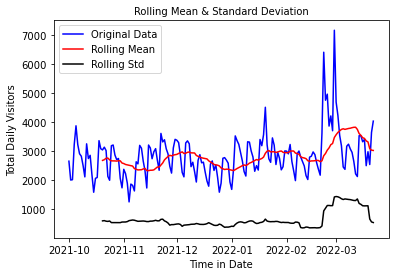

In [348]:
TestStationaryPlot(Visitors_Data)

In [349]:
TestStationaryAdfuller(Visitors_Data)

Test Statistic                  -2.358587
p-value                          0.153768
#Lags Used                      14.000000
Number of Observations Used    158.000000
Critical Value (1%)             -3.472431
Critical Value (5%)             -2.880013
Critical Value (10%)            -2.576619
dtype: float64
Failed to accept null hypothesis. Data is non-stationary 


### Transforming data to Stationary

###### Transforming data to stationary using three following methods:

#### 1.Moving Average 2.Differencing 3.Decomposing

### 1. Moving Average

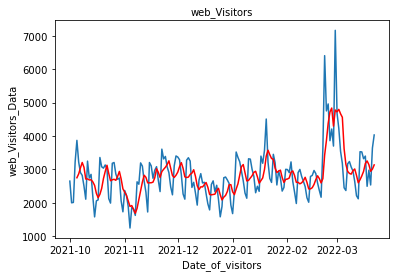

In [350]:
moving_avg = Visitors_Data.rolling(5).mean()
plt.plot(Visitors_Data)
plt.plot(moving_avg, color='red')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Date_of_visitors', fontsize = 10)
plt.ylabel('web_Visitors_Data', fontsize = 10)
plt.title('web_Visitors', fontsize = 10)
plt.show()

In [351]:
moving_avg_diff = Visitors_Data - moving_avg
moving_avg_diff.head(30)

,Daily_Visitors
Date,
2021-10-01,NaN
2021-10-02,NaN
2021-10-03,NaN
2021-10-04,NaN
2021-10-05,1120.2
2021-10-06,357.6
2021-10-07,-139.6
2021-10-08,-386.6
2021-10-09,-563.8


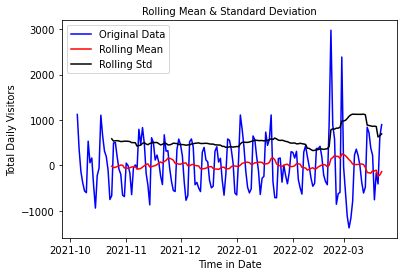

In [352]:
moving_avg_diff.dropna(inplace=True)
TestStationaryPlot(moving_avg_diff)

In [353]:
TestStationaryAdfuller(moving_avg_diff)

Test Statistic                  -3.828015
p-value                          0.002633
#Lags Used                      14.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64
Failed to reject null hypothesis. Data is stationary


### 2. Eliminating trend and seasonality: Differencing

#### 2(A) : First order differencing

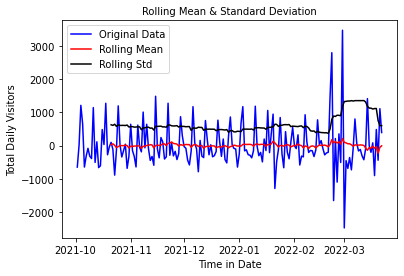

In [354]:
Visitors_Data_first_difference = Visitors_Data - Visitors_Data.shift(1)  
TestStationaryPlot(Visitors_Data_first_difference.dropna(inplace=False))

In [355]:
TestStationaryAdfuller(Visitors_Data_first_difference.dropna(inplace=False))

Test Statistic                -6.607171e+00
p-value                        6.512663e-09
#Lags Used                     1.200000e+01
Number of Observations Used    1.590000e+02
Critical Value (1%)           -3.472161e+00
Critical Value (5%)           -2.879895e+00
Critical Value (10%)          -2.576557e+00
dtype: float64
Failed to reject null hypothesis. Data is stationary


### 2(B) : Seasonal First order differencing

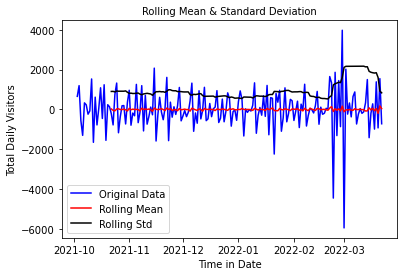

In [356]:
Visitors_Data_seasonal_first_difference = Visitors_Data_first_difference - Visitors_Data_first_difference.shift(1)  
TestStationaryPlot(Visitors_Data_seasonal_first_difference.dropna(inplace=False))

In [357]:
TestStationaryAdfuller(Visitors_Data_seasonal_first_difference.dropna(inplace=False))

Test Statistic                -6.432838e+00
p-value                        1.680769e-08
#Lags Used                     1.300000e+01
Number of Observations Used    1.570000e+02
Critical Value (1%)           -3.472703e+00
Critical Value (5%)           -2.880132e+00
Critical Value (10%)          -2.576683e+00
dtype: float64
Failed to reject null hypothesis. Data is stationary


### 3. Eliminating trend and seasonality: Decomposing

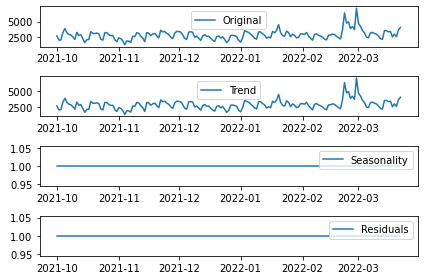

In [358]:
decomposition = seasonal_decompose(Visitors_Data,freq=1,model="multiplicable")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(Visitors_Data, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

#### Here we can see that the trend, no seasonaltiy in data and we can model the trend. Here original data and trend both are equal.

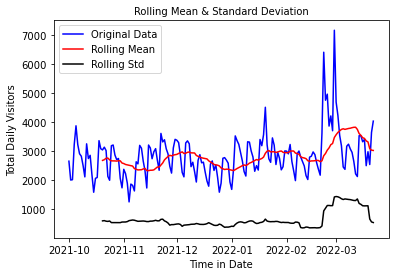

Test Statistic                  -2.358587
p-value                          0.153768
#Lags Used                      14.000000
Number of Observations Used    158.000000
Critical Value (1%)             -3.472431
Critical Value (5%)             -2.880013
Critical Value (10%)            -2.576619
dtype: float64
Failed to accept null hypothesis. Data is non-stationary 


In [359]:
Visitors_Data_decompose = trend
Visitors_Data_decompose.dropna(inplace=True)
TestStationaryPlot(Visitors_Data_decompose)
TestStationaryAdfuller(Visitors_Data_decompose)

## Plot the ACF and PACF charts and find the optimal parameters

#### ACF & PACF plot for seasonal first order difference

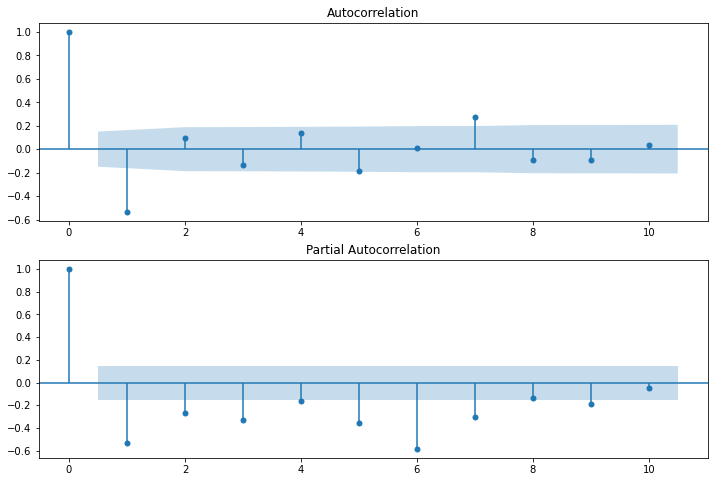

In [360]:
#ACF and PACF plots:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Visitors_Data_seasonal_first_difference.dropna(inplace=False), lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Visitors_Data_seasonal_first_difference.dropna(inplace=False), lags=10, ax=ax2)

##### We will find optimal parameters (p,d,q) using grid search later

### Data Partitioning

##### Training Data = Fit the model only to training period
##### Validating Data = Assess the model performance on validation
##### Deploy model by training on whole dataset
##### No random partition That’s because the order sequence of the time series should be intact in order to use it for forecasting.

In [361]:
#using seasonal first order difference
Visitors_Data_seasonal_first_difference.head()

,Daily_Visitors
Date,
2021-10-01,NaN
2021-10-02,NaN
2021-10-03,660.0
2021-10-04,1197.0
2021-10-05,-557.0


In [362]:
X = Visitors_Data_seasonal_first_difference.dropna(inplace=False)

In [363]:
X.head()

,Daily_Visitors
Date,
2021-10-03,660.0
2021-10-04,1197.0
2021-10-05,-557.0
2021-10-06,-1299.0
2021-10-07,332.0


In [364]:
# Create Training and Test
train = X.iloc[:-20]
test = X.iloc[-20:]

In [365]:
print(train.shape,test.shape)

(151, 1) (20, 1)


In [366]:
train.head()

,Daily_Visitors
Date,
2021-10-03,660.0
2021-10-04,1197.0
2021-10-05,-557.0
2021-10-06,-1299.0
2021-10-07,332.0


In [367]:
test.head()

,Daily_Visitors
Date,
2022-03-03,-232.0
2022-03-04,327.0
2022-03-05,-371.0
2022-03-06,650.0
2022-03-07,880.0


### Hyper-parameter Tuning : Finding out optimal (p,d,q)

In [368]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [369]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [370]:
# evaluate parameters
p_values = [0, 1, 2, 3, 4, 5]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(train.values, test.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=817.326
ARIMA(0, 0, 1) RMSE=590.203
ARIMA(0, 0, 2) RMSE=704.613
ARIMA(0, 1, 0) RMSE=1509.257
ARIMA(0, 1, 1) RMSE=817.321
ARIMA(0, 1, 2) RMSE=587.970
ARIMA(0, 2, 0) RMSE=3494.776
ARIMA(0, 2, 1) RMSE=1514.165
ARIMA(0, 2, 2) RMSE=825.325
ARIMA(1, 0, 0) RMSE=705.415
ARIMA(1, 0, 1) RMSE=603.037
ARIMA(1, 0, 2) RMSE=639.169
ARIMA(1, 1, 0) RMSE=1301.908
ARIMA(1, 1, 1) RMSE=706.016
ARIMA(1, 1, 2) RMSE=626.237
ARIMA(1, 2, 0) RMSE=2345.778
ARIMA(1, 2, 1) RMSE=1307.897
ARIMA(1, 2, 2) RMSE=717.368
ARIMA(2, 0, 0) RMSE=714.197
ARIMA(2, 0, 1) RMSE=656.536
ARIMA(2, 0, 2) RMSE=618.883
ARIMA(2, 1, 0) RMSE=1052.874
ARIMA(2, 1, 1) RMSE=711.160
ARIMA(2, 1, 2) RMSE=657.206
ARIMA(2, 2, 0) RMSE=1766.209
ARIMA(2, 2, 1) RMSE=1058.198
ARIMA(2, 2, 2) RMSE=715.288
ARIMA(3, 0, 0) RMSE=745.966
ARIMA(3, 0, 1) RMSE=675.863
ARIMA(3, 0, 2) RMSE=699.706
ARIMA(3, 1, 0) RMSE=980.848
ARIMA(3, 1, 1) RMSE=745.748
ARIMA(3, 2, 0) RMSE=1641.437
ARIMA(3, 2, 1) RMSE=986.694
ARIMA(3, 2, 2) RMSE=749.657
ARIMA(4, 0

## ARIMA model

In [371]:
#0,1,2
model_arima = ARIMA(train['Daily_Visitors'],order = (0,1,2))
model_arima = model_arima.fit()
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Daily_Visitors   No. Observations:                  151
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1201.180
Date:                Sat, 16 Apr 2022   AIC                           2408.360
Time:                        15:36:25   BIC                           2417.392
Sample:                    10-03-2021   HQIC                          2412.029
                         - 03-02-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9978      0.063    -31.565      0.000      -2.122      -1.874
ma.L2          0.9978      0.064     15.712      0.000       0.873       1.122
sigma2      4.752e+05   2.66e-07   1.78e+12      0.000    4.75e+05    4.75e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.77   Jarque-Bera (JB):               220.37
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               2.30   Skew:                             1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.73e+27. Standard errors may be unstable.
"""

In [372]:
### make prediction on test set
start = len(train)
end = len(train)+len(test)-1
pred_arima = model_arima.predict(start=start,end=end)
print(pred_arima)

2022-03-03    494.078605
2022-03-04      0.383133
2022-03-05      0.383133
2022-03-06      0.383133
2022-03-07      0.383133
2022-03-08      0.383133
2022-03-09      0.383133
2022-03-10      0.383133
2022-03-11      0.383133
2022-03-12      0.383133
2022-03-13      0.383133
2022-03-14      0.383133
2022-03-15      0.383133
2022-03-16      0.383133
2022-03-17      0.383133
2022-03-18      0.383133
2022-03-19      0.383133
2022-03-20      0.383133
2022-03-21      0.383133
2022-03-22      0.383133
Freq: D, Name: predicted_mean, dtype: float64


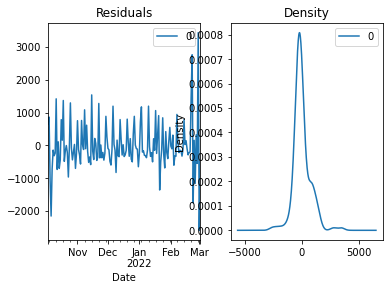

In [373]:
# Plot residual errors
residuals = pd.DataFrame(model_arima.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [374]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

In [375]:
stationary_arima_acc = forecast_accuracy(pred_arima.values, test.values)
stationary_arima_acc

{'mape': 1.05760131374642,
 'me': -17.2320936564161,
 'mae': 661.0333627359385,
 'mpe': -0.9990673080564807,
 'rmse': 821.1930820302401}

### Auto Regressor (AR) model

In [376]:
model_ar = AutoReg(train,lags = 6).fit()
print(model_ar.summary())

                            AutoReg Model Results                             
Dep. Variable:         Daily_Visitors   No. Observations:                  151
Model:                     AutoReg(6)   Log Likelihood               -1132.499
Method:               Conditional MLE   S.D. of innovations            596.690
Date:                Sat, 16 Apr 2022   AIC                             12.893
Time:                        15:36:53   BIC                             13.057
Sample:                    10-09-2021   HQIC                            12.960
                         - 03-02-2022                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept            -7.2505     49.580     -0.146      0.884    -104.426      89.925
Daily_Visitors.L1    -1.1465      0.069    -16.606      0.000      -1.282      -1.011
Daily_Visitors.L2    -1.

In [377]:
pred_ar = model_ar.predict(start=start,end=end,dynamic = False)
print(pred_ar)

2022-03-03    -138.307830
2022-03-04     815.476133
2022-03-05    -600.110210
2022-03-06    1112.348315
2022-03-07     436.007499
2022-03-08   -2970.041454
2022-03-09    1545.577764
2022-03-10     -78.452604
2022-03-11     709.554171
2022-03-12    -762.454869
2022-03-13    1237.495414
2022-03-14    -909.911276
2022-03-15   -1028.244139
2022-03-16     854.998191
2022-03-17     247.203665
2022-03-18     146.457226
2022-03-19    -354.759581
2022-03-20     688.821647
2022-03-21    -974.400621
2022-03-22    -151.794854
Freq: D, dtype: float64


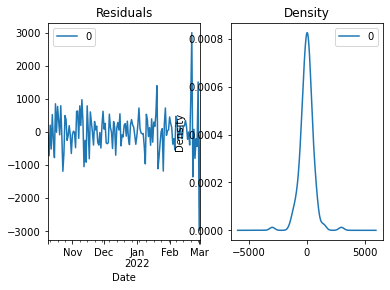

In [378]:
# Plot residual errors
residuals = pd.DataFrame(model_ar.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [379]:
stationary_ar_acc = forecast_accuracy(pred_ar.values, test.values)
stationary_ar_acc

{'mape': 3.0861169170388596,
 'me': -51.02687062398625,
 'mae': 1022.5604132319922,
 'mpe': -1.0003246973166233,
 'rmse': 1301.4579253608265}

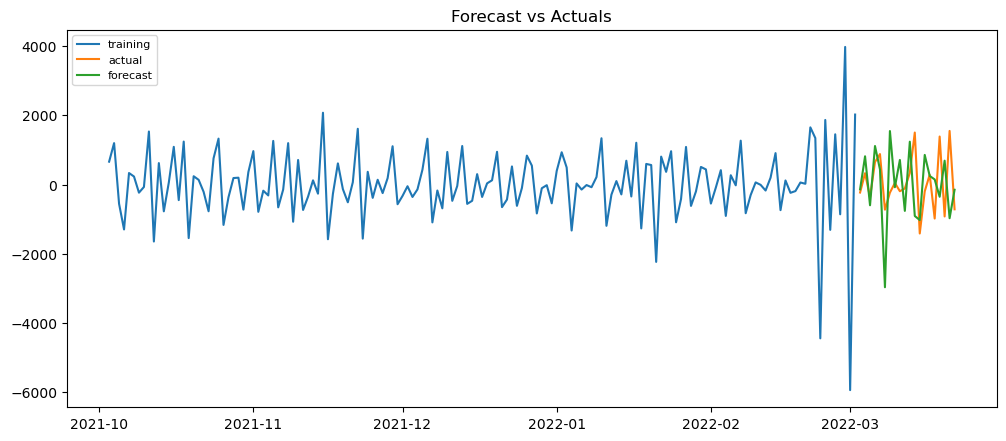

In [380]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ar, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Moving Average (MA) model

In [381]:
# only use q or MA parameter
#MA(3)
model_ma = ARIMA(train['Daily_Visitors'],order = (4,1,2))
model_ma = model_ma.fit()
model_ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Daily_Visitors   No. Observations:                  151
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -1219.141
Date:                Sat, 16 Apr 2022   AIC                           2452.283
Time:                        15:37:12   BIC                           2473.357
Sample:                    10-03-2021   HQIC                          2460.845
                         - 03-02-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7679     33.558     -0.053      0.958     -67.540      64.005
ar.L2         -1.3174     26.460     -0.050      0.960     -53.178      50.543
ar.L3         -0.9340     18.286     -0.051      0.959     -36.775      34.907
ar.L4         -0.3919     13.414     -0.029      0.977     -26.684      25.900
ma.L1         -0.0209     33.549     -0.001      1.000     -65.775      65.733
ma.L2         -0.9791     33.584     -0.029      0.977     -66.802      64.844
sigma2      6.409e+05   2.39e-06   2.68e+11      0.000    6.41e+05    6.41e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):                91.19
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               2.11   Skew:                             0.66
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.2e+29. Standard errors may be unstable.
"""

In [382]:
pred_ma = model_ma.predict(start=start,end=end)
print(pred_ma)

2022-03-03      49.695164
2022-03-04    1232.778021
2022-03-05   -1812.074864
2022-03-06     732.154528
2022-03-07     -86.408729
2022-03-08     389.081202
2022-03-09    -556.004312
2022-03-10     255.715892
2022-03-11     -57.525152
2022-03-12     123.215270
2022-03-13    -171.359730
2022-03-14      85.720214
2022-03-15     -26.730004
2022-03-16      37.679321
2022-03-17     -52.697914
2022-03-18      26.491355
2022-03-19     -10.526241
2022-03-20       9.758499
2022-03-21     -15.874101
2022-03-22       6.254314
Freq: D, Name: predicted_mean, dtype: float64


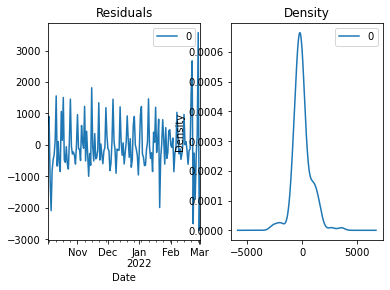

In [383]:
# Plot residual errors
residuals = pd.DataFrame(model_ma.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [384]:
stationary_ma_acc = forecast_accuracy(pred_ma.values, test.values)
stationary_ma_acc

{'mape': 1.6834322257531307,
 'me': -34.332863331772295,
 'mae': 772.7133197133679,
 'mpe': -0.9997035698122722,
 'rmse': 980.0140806622494}

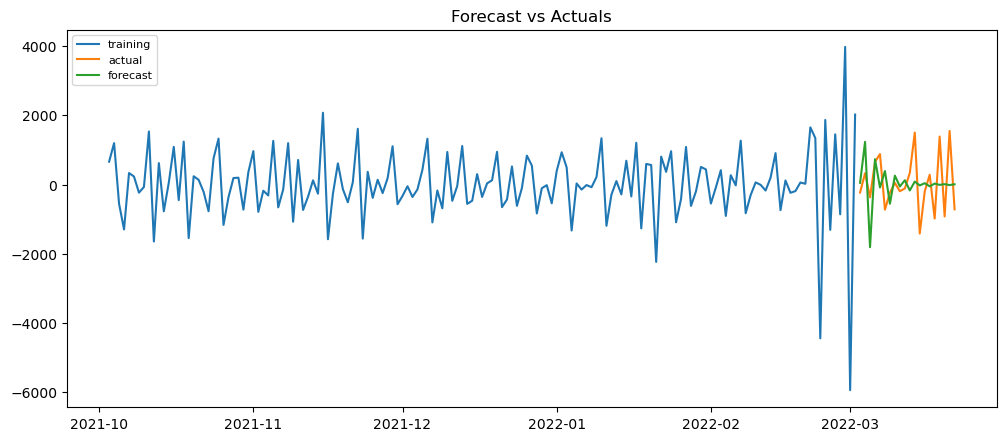

In [385]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ma, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Auto ARIMA model

In [386]:
model = pm.auto_arima(train['Daily_Visitors'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2532.697, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2483.889, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2473.160, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=2455.018, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.28 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=2457.021, Time=0.06 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 0.812 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  151
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -1223.509
Date:                Sat, 16 Apr 2022   AIC                           2455.018
Time:                        15:37:28   BIC        

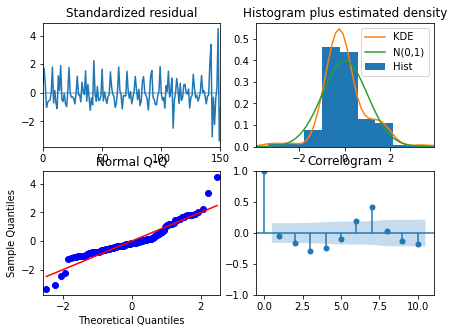

In [387]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [388]:
pred = model.predict(start=start,end=end)
print(pred)

[  102.05275065  1193.27068758 -1821.94108676   740.41383848
   -54.13771634   366.32215243  -560.01262851   262.3916461
   -44.10705728   114.99872702]


In [389]:
stationary_aa_acc = forecast_accuracy(pred, test.values)
stationary_aa_acc

{'mape': 2.350325352982496,
 'me': -12.374868663529009,
 'mae': 891.221040902019,
 'mpe': -0.9988865871555554,
 'rmse': 1115.9821451949974}

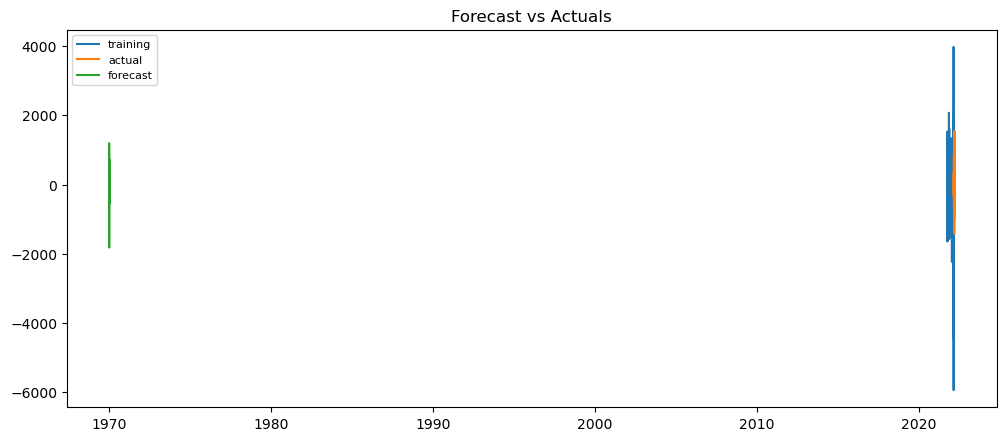

In [390]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [391]:
data = {"MODEL":pd.Series(["ARIMA","Auto Regressor","Moving Average","Auto ARIMA"]),"RMSE_Values":pd.Series([stationary_arima_acc["rmse"],stationary_ar_acc["rmse"],
stationary_ma_acc["rmse"],stationary_aa_acc["rmse"]]),"MAPE_values":pd.Series([stationary_arima_acc["mape"],stationary_ar_acc["mape"],stationary_ma_acc["mape"],stationary_aa_acc["mape"]]),
"ME_values":pd.Series([stationary_arima_acc["me"],stationary_ar_acc["me"],stationary_ma_acc["me"],stationary_aa_acc["me"]]),
"MAE_values":pd.Series([stationary_arima_acc["mae"],stationary_ar_acc["mae"],stationary_ma_acc["mae"],stationary_aa_acc["mae"]]),
        "MPE_values":pd.Series([stationary_arima_acc["mpe"],stationary_ar_acc["mpe"],stationary_ma_acc["mpe"],stationary_aa_acc["mpe"]])}

table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values,MAPE_values,ME_values,MAE_values,MPE_values
0,ARIMA,821.193082,1.057601,-17.232094,661.033363,-0.999067
2,Moving Average,980.014081,1.683432,-34.332863,772.713320,-0.999704
3,Auto ARIMA,1115.982145,2.350325,-12.374869,891.221041,-0.998887
1,Auto Regressor,1301.457925,3.086117,-51.026871,1022.560413,-1.000325


### Final Model

In [392]:
Final_arima = ARIMA(Visitors_Data['Daily_Visitors'],order = (0,1,2))
Final_arima = Final_arima.fit()
Final_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Daily_Visitors   No. Observations:                  173
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -1351.620
Date:                Sat, 16 Apr 2022   AIC                           2709.241
Time:                        15:39:49   BIC                           2718.683
Sample:                    10-01-2021   HQIC                          2713.072
                         - 03-22-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4106      0.054     -7.620      0.000      -0.516      -0.305
ma.L2         -0.2912      0.055     -5.321      0.000      -0.398      -0.184
sigma2      3.852e+05   2.12e+04     18.157      0.000    3.44e+05    4.27e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.78   Jarque-Bera (JB):               445.48
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               2.48   Skew:                             1.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [393]:
final_arima.fittedvalues.tail()

Date
2022-03-18    3051.061048
2022-03-19    2371.128946
2022-03-20    2838.344923
2022-03-21    3719.833660
2022-03-22    3689.969015
dtype: float64

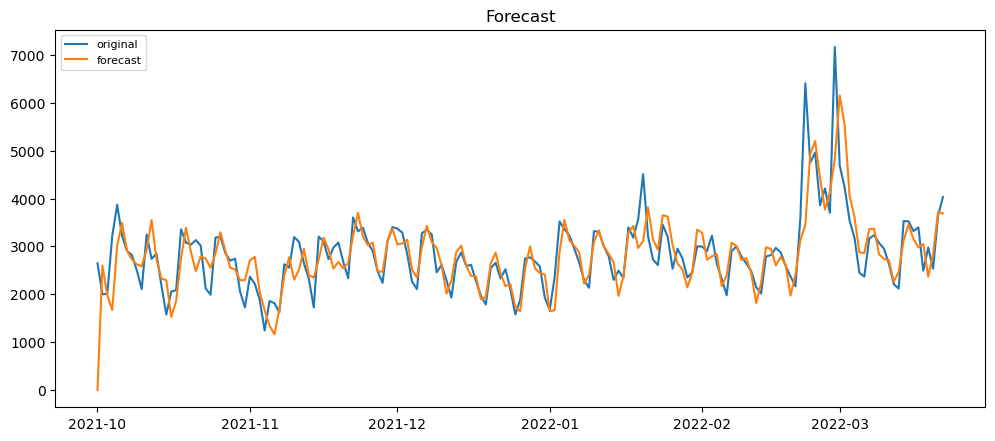

In [394]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(Visitors_Data, label='original')
#plt.plot(test, label='actual')
plt.plot(final_arima.fittedvalues, label='forecast')
plt.title('Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### B) MODEL BUILDING ON NON-STATIONARY DATA / ORIGINAL DATA

In [231]:
Visitors_Data.head()

,Daily_Visitors
Date,
2021-10-01,2649
2021-10-02,2000
2021-10-03,2011
2021-10-04,3219
2021-10-05,3870


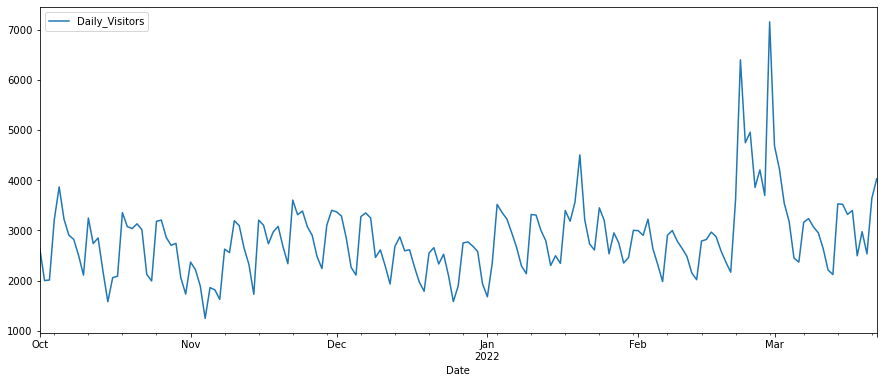

In [232]:
Visitors_Data.plot(figsize=(15, 6))
plt.show()

### Data Partitioning

In [233]:
train = Visitors_Data[:150]
test = Visitors_Data[150:]
print(train.shape,test.shape)

(150, 1) (23, 1)


In [234]:
train.head()

,Daily_Visitors
Date,
2021-10-01,2649
2021-10-02,2000
2021-10-03,2011
2021-10-04,3219
2021-10-05,3870


In [235]:
test.head()

,Daily_Visitors
Date,
2022-02-28,7165
2022-03-01,4687
2022-03-02,4231
2022-03-03,3543
2022-03-04,3182


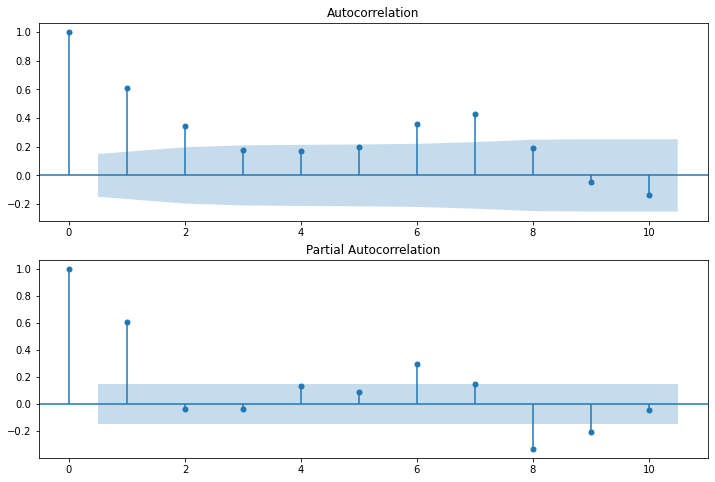

In [236]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Visitors_Data, lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Visitors_Data, lags=10, ax=ax2)

### Hyper-parameter Tuning : Finding out optimal (p,d,q)

In [237]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(train, test, arima_order):
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [238]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
    #dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train, test, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [239]:
# evaluate parameters
p_values = [0,1,2,3,4,5]
d_values = range(0, 5)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train.values, test.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=1168.330
ARIMA(0, 0, 1) RMSE=1075.207
ARIMA(0, 0, 2) RMSE=980.508
ARIMA(0, 0, 3) RMSE=993.508
ARIMA(0, 0, 4) RMSE=970.347
ARIMA(0, 1, 0) RMSE=1045.496
ARIMA(0, 1, 1) RMSE=1020.369
ARIMA(0, 1, 2) RMSE=1018.212
ARIMA(0, 1, 3) RMSE=989.381
ARIMA(0, 1, 4) RMSE=1060.545
ARIMA(0, 2, 0) RMSE=1726.036
ARIMA(0, 2, 1) RMSE=1048.921
ARIMA(0, 2, 2) RMSE=1031.347
ARIMA(0, 2, 3) RMSE=1058.926
ARIMA(0, 2, 4) RMSE=1069.941
ARIMA(0, 3, 0) RMSE=3168.094
ARIMA(0, 3, 1) RMSE=1731.728
ARIMA(0, 3, 2) RMSE=1056.053
ARIMA(0, 3, 3) RMSE=1119.121
ARIMA(0, 3, 4) RMSE=1076.758
ARIMA(0, 4, 0) RMSE=6018.683
ARIMA(0, 4, 1) RMSE=3178.372
ARIMA(0, 4, 2) RMSE=1747.954
ARIMA(0, 4, 3) RMSE=1071.075
ARIMA(0, 4, 4) RMSE=1151.092
ARIMA(1, 0, 0) RMSE=949.739
ARIMA(1, 0, 1) RMSE=977.308
ARIMA(1, 0, 2) RMSE=989.080
ARIMA(1, 0, 3) RMSE=967.526
ARIMA(1, 0, 4) RMSE=1001.982
ARIMA(1, 1, 0) RMSE=1023.674
ARIMA(1, 1, 1) RMSE=955.093
ARIMA(1, 1, 2) RMSE=1002.350
ARIMA(1, 1, 3) RMSE=1009.860
ARIMA(1, 1, 4) RMSE=108

## ARIMA

In [240]:
model_arima = ARIMA(train['Daily_Visitors'],order = (5,1,4))
model_arima = model_arima.fit()
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Daily_Visitors   No. Observations:                  150
Model:                 ARIMA(5, 1, 4)   Log Likelihood               -1120.138
Date:                Sat, 16 Apr 2022   AIC                           2260.275
Time:                        13:08:24   BIC                           2290.315
Sample:                    10-01-2021   HQIC                          2272.480
                         - 02-27-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3465      0.149      2.325      0.020       0.054       0.639
ar.L2         -1.0548      0.137     -7.681      0.000      -1.324      -0.786
ar.L3          0.1262      0.225      0.561      0.575      -0.314       0.567
ar.L4         -0.6226      0.127     -4.889      0.000      -0.872      -0.373
ar.L5         -0.4428      0.144     -3.084      0.002      -0.724      -0.161
ma.L1         -0.7296      0.136     -5.373      0.000      -0.996      -0.463
ma.L2          1.1999      0.173      6.945      0.000       0.861       1.539
ma.L3         -0.6152      0.169     -3.650      0.000      -0.946      -0.285
ma.L4          0.8783      0.157      5.593      0.000       0.571       1.186
sigma2       2.59e+05   4.88e+04      5.304      0.000    1.63e+05    3.55e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1224.06
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                             2.29
Prob(H) (two-sided):                  0.07   Kurtosis:                        16.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [241]:
start = len(train)
end = len(train)+len(test)-1
pred_arima = model_arima.predict(start=start,end=end)
print(pred_arima)

2022-02-28    4409.345982
2022-03-01    4922.247279
2022-03-02    4797.373751
2022-03-03    4183.419882
2022-03-04    3951.099936
2022-03-05    3868.581620
2022-03-06    3858.234836
2022-03-07    4349.943166
2022-03-08    4937.292332
2022-03-09    4775.067864
2022-03-10    4204.347566
2022-03-11    3950.260733
2022-03-12    3860.335485
2022-03-13    3866.130955
2022-03-14    4358.116683
2022-03-15    4922.011324
2022-03-16    4767.654474
2022-03-17    4217.663457
2022-03-18    3952.180369
2022-03-19    3851.915277
2022-03-20    3874.250817
2022-03-21    4365.045034
2022-03-22    4907.693391
Freq: D, Name: predicted_mean, dtype: float64


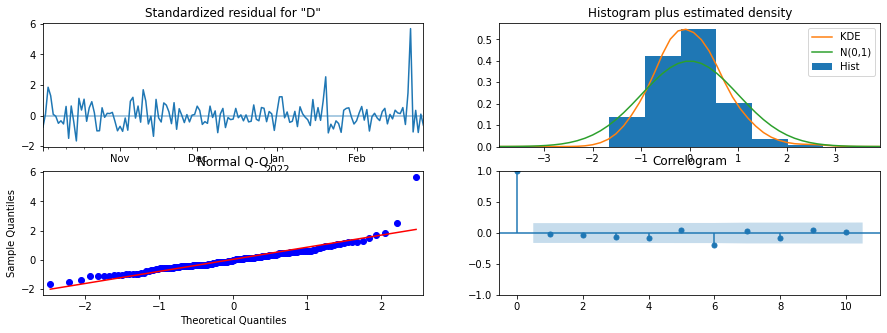

In [242]:
model_arima.plot_diagnostics(figsize=(15,5))
plt.show()

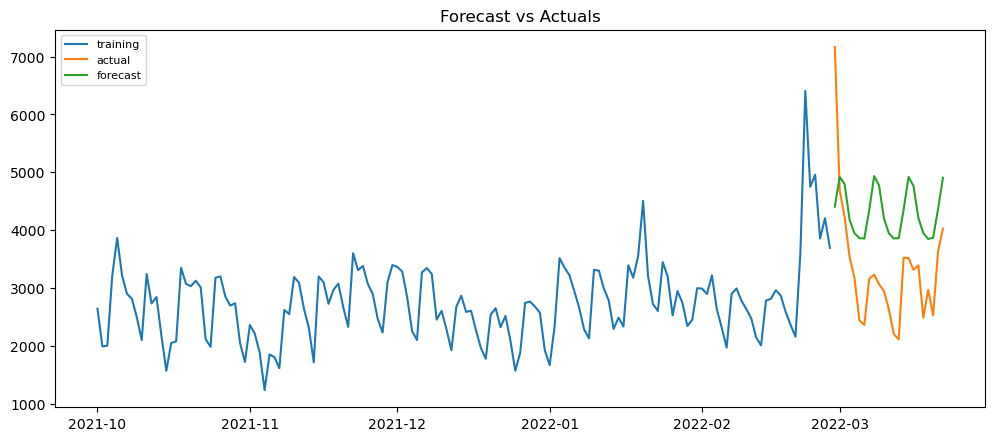

In [243]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_arima, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [244]:
ns_arima_acc = forecast_accuracy(pred_arima,test.Daily_Visitors)
ns_arima_acc

{'mape': 0.4032553919114973,
 'me': 985.9222702687747,
 'mae': 1225.5443588085182,
 'mpe': 0.36981197411111444,
 'rmse': 1332.5118228334932}

## Auto ARIMA

In [245]:
model_auto = pm.auto_arima(train['Daily_Visitors'], start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2330.154, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2331.037, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2330.069, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2328.176, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.503 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  150
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1163.088
Date:                Sat, 16 Apr 2022   AIC                           2328.176
Time:                        13:09:35   BIC                           2331.180
Sample:                             0   HQIC                          2329.396
                                - 150                                         
Co

In [246]:
pred_auto_arima = model_auto.predict(start=start,end=end)
print(pred_auto_arima)

[3699. 3699. 3699. 3699. 3699. 3699. 3699. 3699. 3699. 3699.]


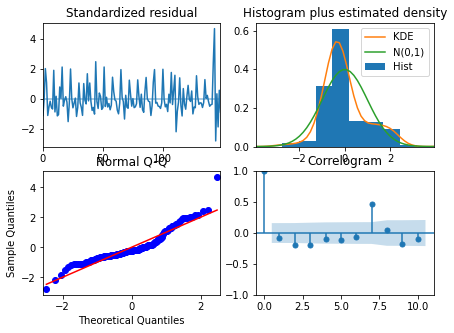

In [247]:
model_auto.plot_diagnostics(figsize=(7,5))
plt.show()

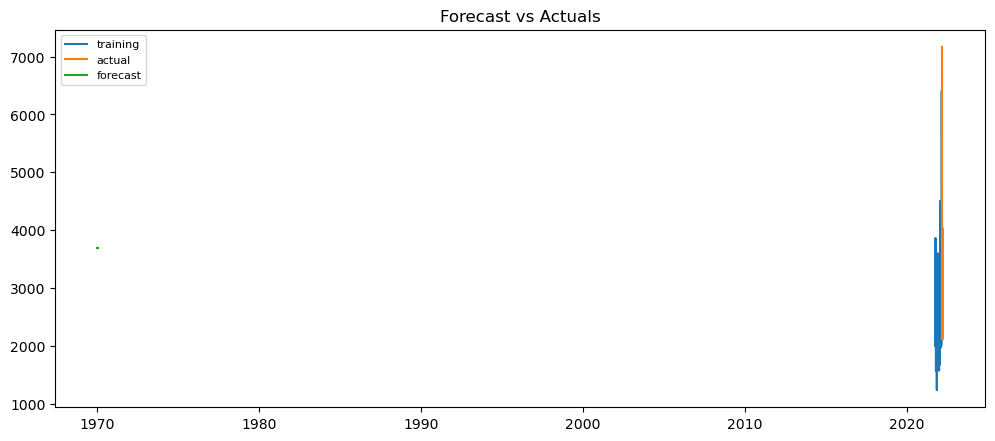

In [248]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_auto_arima, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Auto Regressor

In [249]:
model_ar = AutoReg(train,lags = 1).fit()
print(model_ar.summary())

                            AutoReg Model Results                             
Dep. Variable:         Daily_Visitors   No. Observations:                  150
Model:                     AutoReg(1)   Log Likelihood               -1147.823
Method:               Conditional MLE   S.D. of innovations            536.236
Date:                Sat, 16 Apr 2022   AIC                             12.609
Time:                        13:09:57   BIC                             12.670
Sample:                    10-02-2021   HQIC                            12.634
                         - 02-27-2022                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept          1041.9588    183.211      5.687      0.000     682.872    1401.045
Daily_Visitors.L1     0.6233      0.065      9.629      0.000       0.496       0.750
                        

In [250]:
pred_ar = model_ar.predict(start=start,end=end,dynamic = False)
print(pred_ar)

2022-02-28    3347.721641
2022-03-01    3128.753114
2022-03-02    2992.259604
2022-03-03    2907.176700
2022-03-04    2854.140475
2022-03-05    2821.080471
2022-03-06    2800.472596
2022-03-07    2787.626726
2022-03-08    2779.619284
2022-03-09    2774.627864
2022-03-10    2771.516474
2022-03-11    2769.576997
2022-03-12    2768.368028
2022-03-13    2767.614420
2022-03-14    2767.144661
2022-03-15    2766.851837
2022-03-16    2766.669306
2022-03-17    2766.555526
2022-03-18    2766.484602
2022-03-19    2766.440391
2022-03-20    2766.412832
2022-03-21    2766.395654
2022-03-22    2766.384945
Freq: D, dtype: float64


In [251]:
ns_ar_acc = forecast_accuracy(pred_ar.values, test.values)
ns_ar_acc

{'mape': 0.20065977975005908,
 'me': -491.4828631389155,
 'mae': 761.2185496116282,
 'mpe': -0.08532251381945737,
 'rmse': 1155.2329557462695}

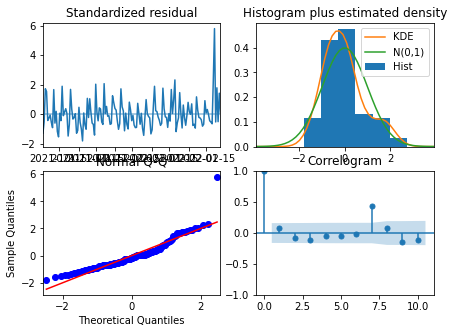

In [252]:
model_ar.plot_diagnostics(figsize=(7,5))
plt.show()

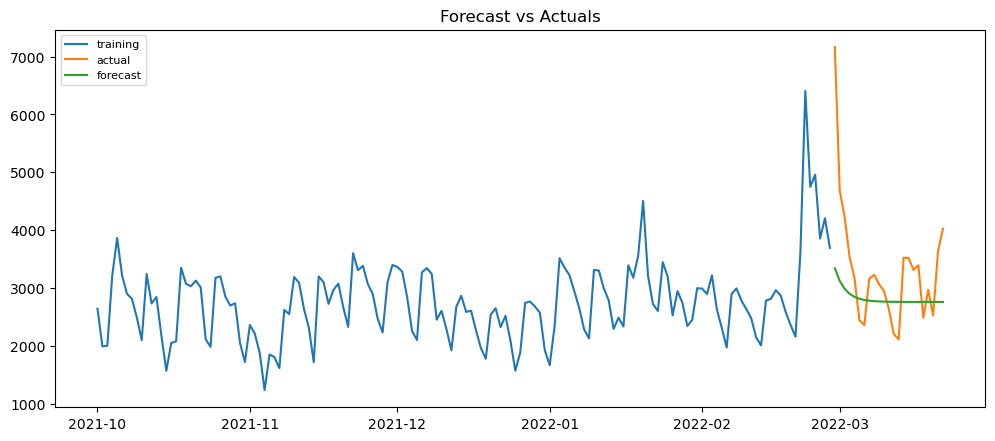

In [253]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ar, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Single Exponential Smoothing

In [260]:
fit1 = SimpleExpSmoothing(train).fit(smoothing_level = 0.2,optimized = False)
fit2 =SimpleExpSmoothing(train).fit(smoothing_level = 0.8,optimized = False)

Text(0.5, 1.0, 'Fitted values Vs Original Values')

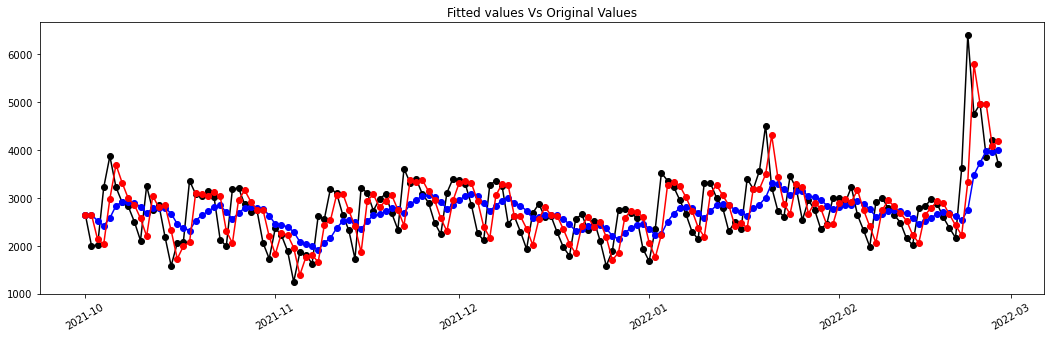

In [261]:
plt.figure(figsize=(18,5))
plt.plot(train,marker = 'o',color = 'black')
plt.xticks(rotation=30)
plt.plot(fit1.fittedvalues,marker = 'o',color = 'blue')
plt.plot(fit2.fittedvalues,marker = 'o',color = 'red')
plt.title('Fitted values Vs Original Values')

In [262]:
pred_ses = fit1.predict(start = len(train),end = len(train)+len(test)-1)

In [263]:
ns_ses_acc = forecast_accuracy(pred_ses,test.Daily_Visitors)
ns_ses_acc

{'mape': 0.33396363769454357,
 'me': 619.6224024996466,
 'mae': 996.6384288513759,
 'mpe': 0.2733548884466769,
 'rmse': 1207.232500843737}

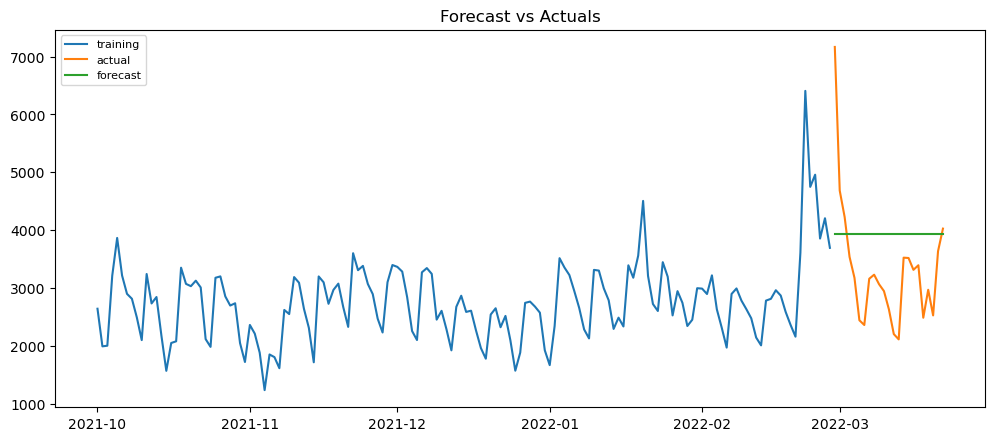

In [264]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ses, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Double Exponential Smoothing or Holt's method

In [265]:
fit3 = Holt(train,exponential=True,damped_trend=False).fit()

Text(0.5, 1.0, 'Fitted values Vs Original Values')

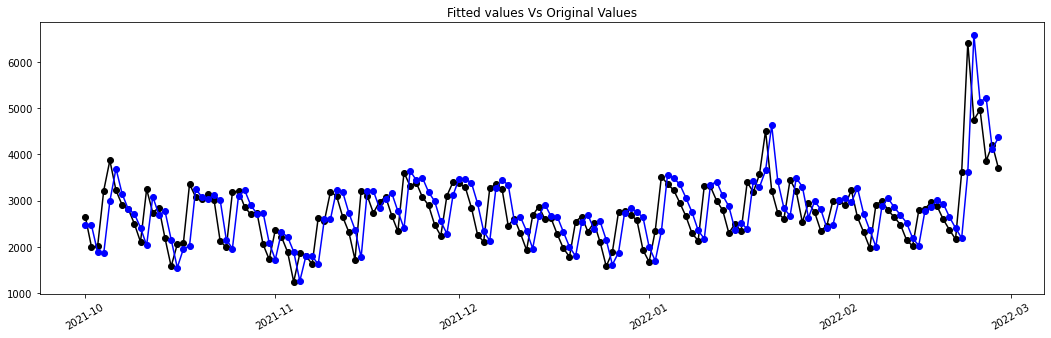

In [266]:
plt.figure(figsize=(18,5))
plt.plot(train,marker = 'o',color = 'black')
plt.xticks(rotation=30)
plt.plot(fit3.fittedvalues,marker = 'o',color = 'blue')
#plt.plot(fit2.fittedvalues,marker = 'o',color = 'red')
plt.title('Fitted values Vs Original Values')

In [267]:
pred_holt = fit3.predict(start = len(train),end = len(train)+len(test)-1)

In [268]:
ns_des_acc = forecast_accuracy(pred_holt,test.Daily_Visitors)
ns_des_acc

{'mape': 0.8814657028223188,
 'me': 2273.353212251554,
 'mae': 2629.6346878662457,
 'mpe': 0.8263767609088228,
 'rmse': 2892.893325864056}

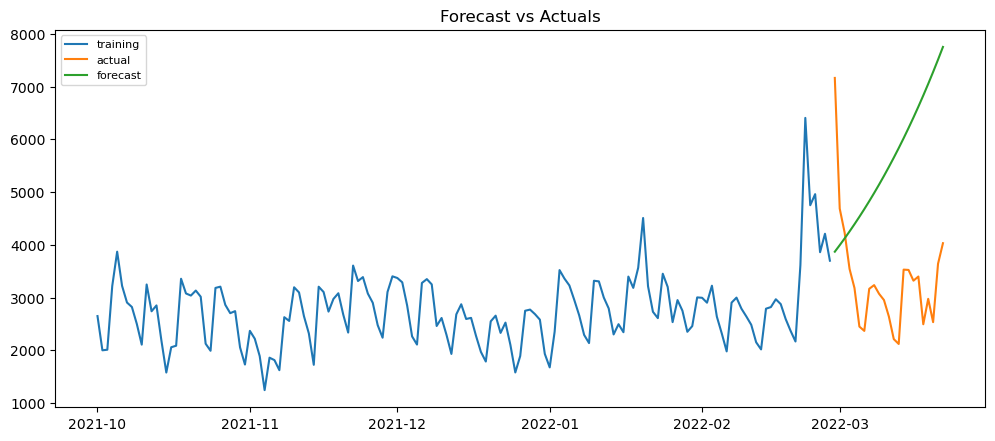

In [269]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_holt, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Triple Exponential Smoothing or Holt - Winter's Method

In [270]:
# Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(train["Daily_Visitors"],seasonal="add",trend="add",seasonal_periods=2,damped=True).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = start,end = end)

In [271]:
ns_tes_add_add_acc = forecast_accuracy(pred_hwe_add_add,test.Daily_Visitors)
ns_tes_add_add_acc

{'mape': 0.37008445331056433,
 'me': 735.9164390527596,
 'mae': 1098.5232154235055,
 'mpe': 0.3123876549179775,
 'rmse': 1295.803497647557}

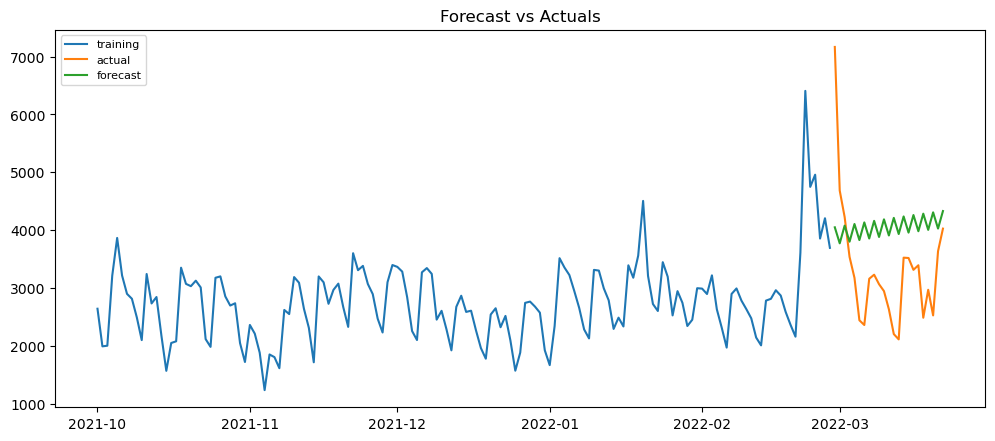

In [272]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_hwe_add_add, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [273]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(train["Daily_Visitors"],seasonal="mul",trend="add",seasonal_periods=2).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = start,end = end)

In [274]:
ns_tes_mul_add_acc = forecast_accuracy(pred_hwe_mul_add,test.Daily_Visitors)
ns_tes_mul_add_acc

{'mape': 0.4053095920005639,
 'me': 840.4210662394123,
 'mae': 1204.683823021972,
 'mpe': 0.3475311816201858,
 'rmse': 1381.135340227018}

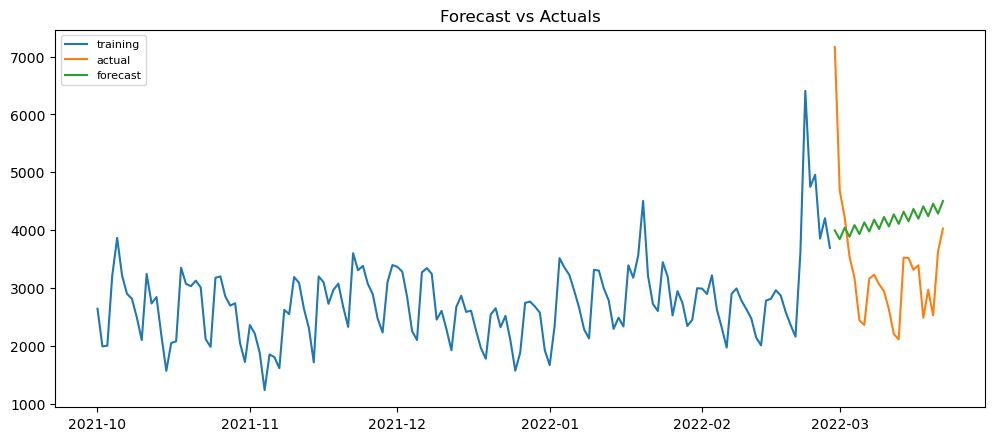

In [275]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_hwe_mul_add, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [276]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_mul = ExponentialSmoothing(train["Daily_Visitors"],seasonal="mul",trend="mul",seasonal_periods=2).fit()
pred_hwe_mul_mul = hwe_model_mul_add.predict(start = start,end = end)

In [277]:
ns_tes_mul_mul_acc = forecast_accuracy(pred_hwe_mul_mul,test.Daily_Visitors)
ns_tes_mul_mul_acc

{'mape': 0.4053095920005639,
 'me': 840.4210662394123,
 'mae': 1204.683823021972,
 'mpe': 0.3475311816201858,
 'rmse': 1381.135340227018}

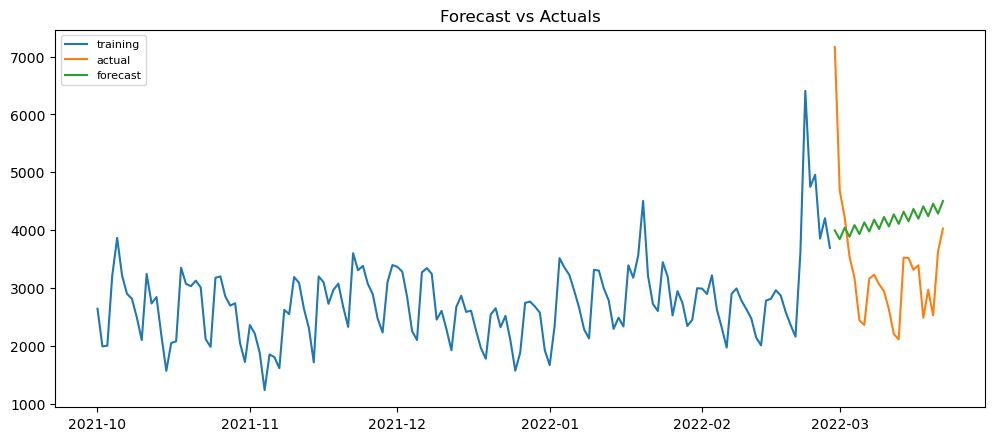

In [278]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_hwe_mul_mul, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## LSTM using RNN

In [279]:
scaler = MinMaxScaler()

In [280]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [281]:
scaled_train[:10]

array([[0.2719876 ],
       [0.14626114],
       [0.1483921 ],
       [0.38240992],
       [0.50852383],
       [0.38299109],
       [0.32177451],
       [0.30530802],
       [0.24312282],
       [0.16718326]])

In [282]:
#define generator
n_input = 5
n_features = 1
generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [283]:
X,y = generator[0]
print(f'given the array: \n{X.flatten()}')
print(f'predict this y: \n {y}')

given the array: 
[0.2719876  0.14626114 0.1483921  0.38240992 0.50852383]
predict this y: 
 [[0.38299109]]


In [284]:
X.shape

(1, 5, 1)

In [286]:
#define model
model = Sequential()
model.add(LSTM(60, activation = 'relu',return_sequences = True, input_shape=(n_input,n_features)))
model.add(Dropout(0.2))

model.add(LSTM(60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(60, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1))
model.compile(optimizer='adam',loss='mean_squared_error')

In [287]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 60)             14880     
_________________________________________________________________
dropout (Dropout)            (None, 5, 60)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 60)             29040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 60)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 60)             29040     
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 60)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60)               

In [288]:
#fit model
model.fit(generator,epochs=50,batch_size=32,verbose=1)

Epoch 1/50
145/145 [==============================] - 7s 8ms/step - loss: 0.0288
Epoch 2/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0186
Epoch 3/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0191
Epoch 4/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0201
Epoch 5/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0183
Epoch 6/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0201
Epoch 7/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0179
Epoch 8/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0191
Epoch 9/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0192
Epoch 10/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0193
Epoch 11/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0173
Epoch 12/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0175
Epoch 13/50
145/145 [====

Text(0.5, 1.0, 'Loss per Epochs')

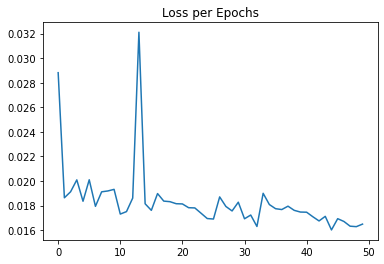

In [289]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
plt.title('Loss per Epochs')

In [290]:
last_train_batch = scaled_train[-5:]

In [291]:
last_train_batch = last_train_batch.reshape(1,n_input,n_features)

In [292]:
model.predict(last_train_batch)

array([[0.32172698]], dtype=float32)

In [293]:
scaled_test[0]

array([1.14684231])

In [294]:
test_predictions =[]

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape(1,n_input,n_features)

for i in range(len(test)):
    
    #get the prediction value for first batch
    current_pred = model.predict(current_batch)[0]
    
    #append the prediction into the array
    test_predictions.append(current_pred)
    
    #use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis =1)

In [295]:
test_predictions

[array([0.32172698], dtype=float32),
 array([0.29530638], dtype=float32),
 array([0.27000475], dtype=float32),
 array([0.26727873], dtype=float32),
 array([0.2668814], dtype=float32),
 array([0.26768836], dtype=float32),
 array([0.26813143], dtype=float32),
 array([0.2684457], dtype=float32),
 array([0.26849926], dtype=float32),
 array([0.2685055], dtype=float32),
 array([0.2684943], dtype=float32),
 array([0.26848656], dtype=float32),
 array([0.26848203], dtype=float32),
 array([0.26848105], dtype=float32),
 array([0.26848093], dtype=float32),
 array([0.2684811], dtype=float32),
 array([0.26848122], dtype=float32),
 array([0.26848128], dtype=float32),
 array([0.2684813], dtype=float32),
 array([0.2684813], dtype=float32),
 array([0.2684813], dtype=float32),
 array([0.2684813], dtype=float32),
 array([0.2684813], dtype=float32)]

In [296]:
test.head()

,Daily_Visitors
Date,
2022-02-28,7165
2022-03-01,4687
2022-03-02,4231
2022-03-03,3543
2022-03-04,3182


In [297]:
true_predictions = scaler.inverse_transform(test_predictions)

In [298]:
test['Predictions'] = true_predictions

<AxesSubplot:xlabel='Date'>

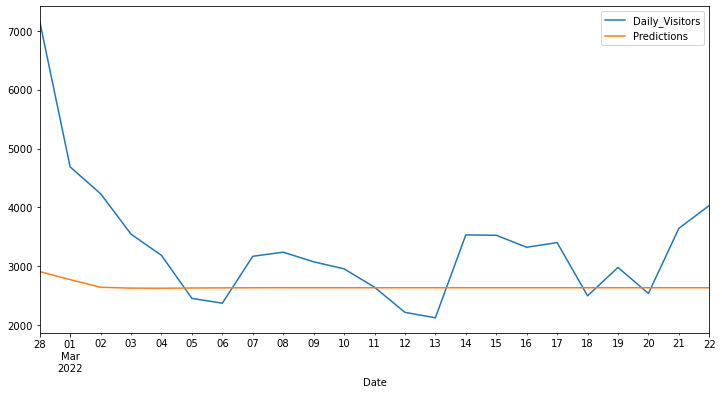

In [299]:
test.plot(figsize=(12,6))

In [300]:
ns_lstm_acc = forecast_accuracy(test['Predictions'],test.Daily_Visitors)
ns_lstm_acc

{'mape': 0.20936002574010873,
 'me': -676.6233774501344,
 'mae': 815.884793429271,
 'mpe': -0.14797515001520778,
 'rmse': 1194.1022184734516}

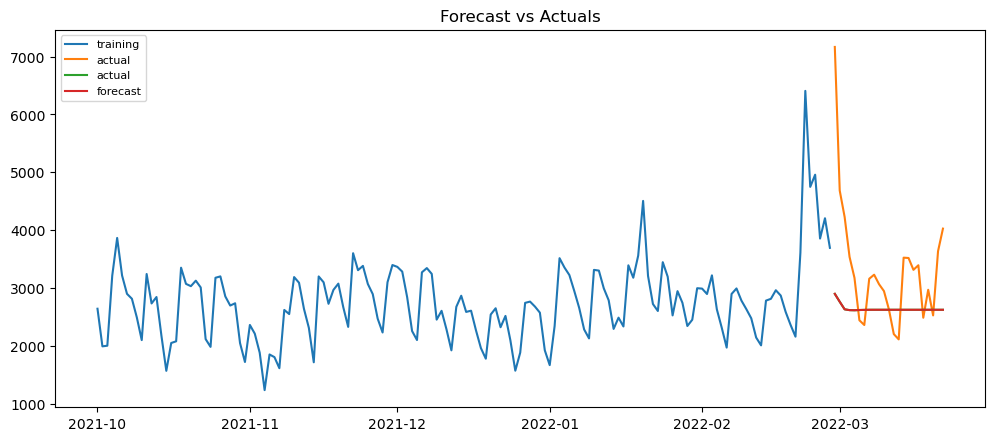

In [301]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(test['Predictions'], label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Forecasting Accuracy

In [304]:
data = {"MODEL":pd.Series(["ARIMA(5,1,4)","Auto Regressor","single exponential smoothing","Double exponential smoothing","Triple exponential smoothing(additive seasonality & additive trend)","Triple exponential smoothing(multiplicative seasonality & additive trend)","Triple exponential smoothing(multiplicative seasonality & multiplicative trend)","LSTM(RNN)"]),
"RMSE_values":pd.Series([ns_arima_acc["rmse"],ns_ar_acc["rmse"],ns_ses_acc["rmse"],ns_des_acc["rmse"],ns_tes_add_add_acc["rmse"],ns_tes_mul_add_acc["rmse"],ns_tes_mul_mul_acc["rmse"],ns_lstm_acc["rmse"]]),
"MAPE_values":pd.Series([ns_arima_acc["mape"],ns_ar_acc["mape"],ns_ses_acc["mape"],ns_des_acc["mape"],ns_tes_add_add_acc["mape"],ns_tes_mul_add_acc["mape"],ns_tes_mul_mul_acc["mape"],ns_lstm_acc["mape"]]),
"ME_values":pd.Series([ns_arima_acc["me"],ns_ar_acc["me"],ns_ses_acc["me"],ns_des_acc["me"],ns_tes_add_add_acc["me"],ns_tes_mul_add_acc["me"],ns_tes_mul_mul_acc["me"],ns_lstm_acc["me"]]),
"MAE_values":pd.Series([ns_arima_acc["mae"],ns_ar_acc["mae"],ns_ses_acc["mae"],ns_des_acc["mae"],ns_tes_add_add_acc["mae"],ns_tes_mul_add_acc["mae"],ns_tes_mul_mul_acc["mae"],ns_lstm_acc["mae"]]),
"MPE_values":pd.Series([ns_arima_acc["mpe"],ns_ar_acc["mpe"],ns_ses_acc["mpe"],ns_des_acc["mpe"],ns_tes_add_add_acc["mpe"],ns_tes_mul_add_acc["mpe"],ns_tes_mul_mul_acc["mpe"],ns_lstm_acc["mpe"]])}

table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['MAPE_values'])

,MODEL,RMSE_values,MAPE_values,ME_values,MAE_values,MPE_values
1,Auto Regressor,1155.232956,0.200660,-491.482863,761.218550,-0.085323
7,LSTM(RNN),1194.102218,0.209360,-676.623377,815.884793,-0.147975
2,single exponential smoothing,1207.232501,0.333964,619.622402,996.638429,0.273355
4,Triple exponential smoothing(additive seasonal...,1295.803498,0.370084,735.916439,1098.523215,0.312388
0,"ARIMA(5,1,4)",1332.511823,0.403255,985.922270,1225.544359,0.369812
5,Triple exponential smoothing(multiplicative se...,1381.135340,0.405310,840.421066,1204.683823,0.347531
6,Triple exponential smoothing(multiplicative se...,1381.135340,0.405310,840.421066,1204.683823,0.347531
3,Double exponential smoothing,2892.893326,0.881466,2273.353212,2629.634688,0.826377
